### GeoPandas detailed mapping
In this example, I'll cover some of the methods I found to achieve the result I wanted, and work around some particular issues I had

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

# This little library contains a specific function to ameliorate the problem of overlapping data labels - it works!
# http://adjusttext.readthedocs.io/en/latest/
import adjustText as aT

### Import shapefiles
The required shapefiles can be found at https://gadm.org/download_country_v3.html<br>
The shapefiles usually come zipped and contain a *.shp* file as well as *.cpg, .dbf, .prj, .shx* files. 
Copy all of them to your working folder before you start.

In [2]:
# Let's import the .shp file that represents the 52 districts of South Africa
za = gpd.read_file("gadm36_ZAF_3.shp")

### Import towns of interest

In [3]:
# Here we import a dataframe which will hold our towns of interest and some data fields to plot
towns = pd.read_excel("Town data.xlsx")
towns.head(3)

,Town,Latitude,Longitude,Assessment,Staff,Region
0,Amanzimtoti,-30.051484,30.886031,0.97,2,Kwazulu Natal
1,Atlantis,-33.562167,18.496204,0.96,2,Western Cape
2,Bethlehem,-28.233051,28.303996,0.94,5,Free State


In [4]:
# Here we convert this information to a GeoPandas dataframe with points and then plot the spatial relations
# between towns and regions using sjoin
geometry = [Point(xy) for xy in zip(towns["Longitude"], towns["Latitude"])]
crs = {'init': 'epsg:4326'}
towns_points = GeoDataFrame(towns[["Town", "Assessment", "Staff"]], crs=crs, geometry=geometry)

# The Label column will be used to label the data points further on
towns_points["Label"] = towns_points["Town"].map(str) + " - " + towns_points["Staff"].map(str)
za_with_town = gpd.sjoin(za, towns_points, how="inner", op='intersects')
towns_points.head()

,Town,Assessment,Staff,geometry,Label
index_right,,,,,
0,Amanzimtoti,0.97,2,POINT (30.886031 -30.051484),Amanzimtoti - 2
1,Atlantis,0.96,2,POINT (18.4962044 -33.5621667),Atlantis - 2
2,Bethlehem,0.94,5,POINT (28.303996 -28.233051),Bethlehem - 5
3,Bloemfontein,0.92,79,POINT (26.2197103 -29.1140553),Bloemfontein - 79
4,Caledon,0.88,3,POINT (19.4277762 -34.2353047),Caledon - 3


### Now let's visualize the results

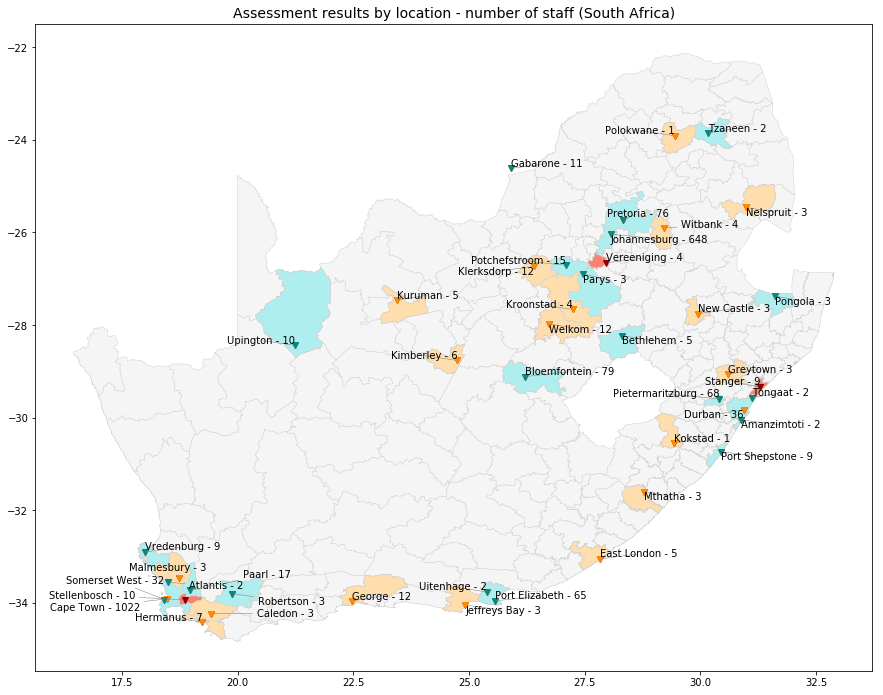

In [5]:
# Here we lay down the basic map of South Africa
ax = za.plot(figsize = (15, 12), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5)

# Here we plot the provinces, with the rule being "highest score trumps"
za_with_town[za_with_town["Assessment"] >= 0.0].plot(ax = ax, color = "salmon", edgecolor = "lightgrey", linewidth = 0.5)
za_with_town[za_with_town["Assessment"] > 0.6].plot(ax = ax, color = "navajowhite", edgecolor = "lightgrey", linewidth = 0.5)
za_with_town[za_with_town["Assessment"] >= 0.9].plot(ax = ax, color = "paleturquoise", edgecolor = "lightgrey", linewidth = 0.5)

# Here we plot the towns, and their individual assessment scores by color
plt.scatter(towns.loc[towns["Assessment"] >= 0.0, "Longitude"], towns.loc[towns["Assessment"] >= 0.0, "Latitude"], 
            marker = "v", color = "darkred")
plt.scatter(towns.loc[towns["Assessment"] > 0.6, "Longitude"], towns.loc[towns["Assessment"] > 0.6, "Latitude"], 
            marker = "v", color = "darkorange")
plt.scatter(towns.loc[towns["Assessment"] >= 0.9, "Longitude"], towns.loc[towns["Assessment"] >= 0.9, "Latitude"], 
            marker = "v", color = "darkcyan")

# This is a simple title :)
plt.title("Assessment results by location - number of staff (South Africa)", size = 14)

# Now we plot the texts for each scatter point using the "Label" column defined earlier
texts = []
for x, y, label in zip(towns_points.geometry.x, towns_points.geometry.y, towns_points["Label"]):
    texts.append(plt.text(x, y, label))

# And NOW we adjust those points so that they no longer overlap
aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

# The figure is then saved at a good resolution for presenting
plt.savefig("assess_za.png", dpi = 800)

### What about a single province?

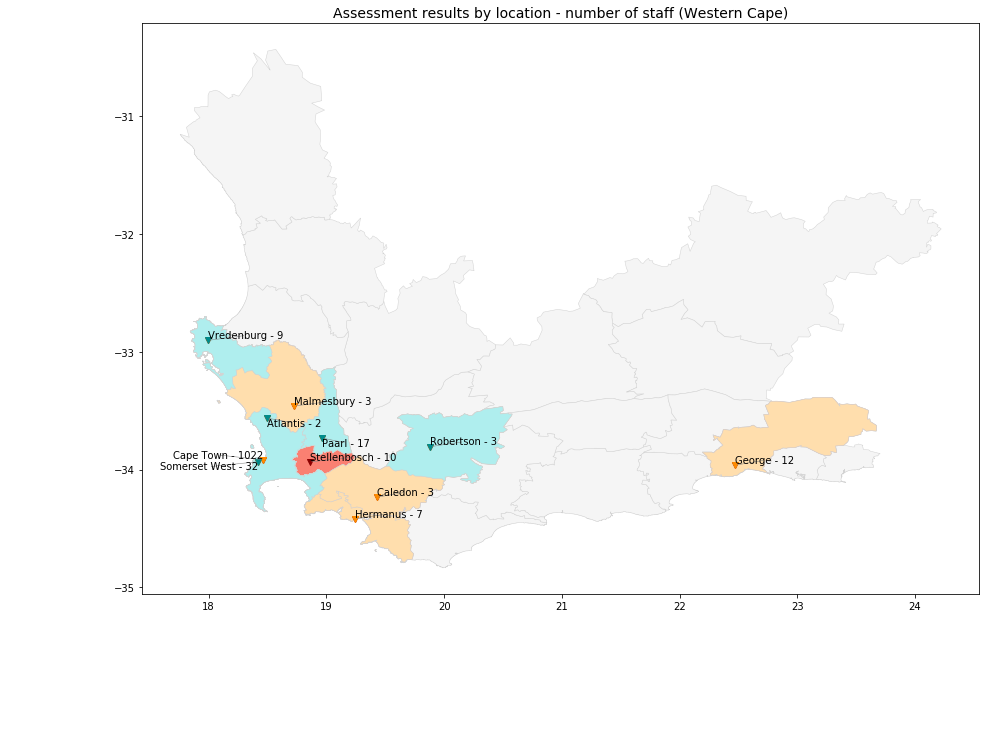

In [6]:
# This is essentially the same code - but filtered to only display the Western Cape province
za_with_town = gpd.sjoin(za, towns_points, how="inner", op='intersects')
ax = za[za["NAME_1"] == "Western Cape"].plot(figsize = (15, 12), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5)
za_with_town[(za_with_town["NAME_1"] == "Western Cape") & (za_with_town["Assessment"] >= 0.0)].plot(ax = ax, color = "salmon", edgecolor = "lightgrey", linewidth = 0.5)
za_with_town[(za_with_town["NAME_1"] == "Western Cape") & (za_with_town["Assessment"] > 0.6)].plot(ax = ax, color = "navajowhite", edgecolor = "lightgrey", linewidth = 0.5)
za_with_town[(za_with_town["NAME_1"] == "Western Cape") & (za_with_town["Assessment"] >= 0.9)].plot(ax = ax, color = "paleturquoise", edgecolor = "lightgrey", linewidth = 0.5)
plt.scatter(towns.loc[(towns["Region"] == "Western Cape") & (towns["Assessment"] >= 0.0), "Longitude"], towns.loc[(towns["Region"] == "Western Cape") & (towns["Assessment"] >= 0.0), "Latitude"], 
            marker = "v", color = "darkred")
plt.scatter(towns.loc[(towns["Region"] == "Western Cape") & (towns["Assessment"] > 0.6), "Longitude"], towns.loc[(towns["Region"] == "Western Cape") & (towns["Assessment"] > 0.6), "Latitude"], 
            marker = "v", color = "darkorange")
plt.scatter(towns.loc[(towns["Region"] == "Western Cape") & (towns["Assessment"] >= 0.9), "Longitude"], towns.loc[(towns["Region"] == "Western Cape") & (towns["Assessment"] >= 0.9), "Latitude"], 
            marker = "v", color = "darkcyan")
plt.title("Assessment results by location - number of staff (Western Cape)", size = 14)
texts = []
for x, y, label in zip(towns_points.geometry.x, towns_points.geometry.y, towns_points["Label"]):
    texts.append(plt.text(x, y, label))
aT.adjust_text(texts, force_points=0.5, force_text=0.9, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
plt.savefig("assess_wc", dpi = 800)